## Import Libraries

In [19]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Performance metrics calculation support library
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error

# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt


## Data preprocessing

### Read data

In [20]:
df = pd.read_csv('../../../../Dataset/NTR.csv')
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [21]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [22]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [23]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [24]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [25]:
# Install library pmdarima
!pip install pmdarima

### Training process

In [26]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [27]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4201.066, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4208.775, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4207.000, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4206.991, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4210.407, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4205.063, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.096 seconds


In [28]:
# Fit the model
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Validate Processing

In [29]:
# Preparing validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(n_periods = len(y_val))

### Testing Processing

In [30]:
x_test = np.array(range(test_size, train_size + val_size + test_size)).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

### Evaluate Model

In [31]:
# Evaluate the accuracy of validation
y_val = scaler.inverse_transform(np.array([y_val]).reshape(-1, 1))
y_pred_val = scaler.inverse_transform(np.array([y_pred_val]).reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: ", val_mape)
print(f"RMSE on Validate set: ", val_rmse)
print(f"MSLE on Validate set: ", val_msle)

MAPE on Validate set:  0.11328617921830787
RMSE on Validate set:  8.798350739227091
MSLE on Validate set:  0.017250355535359144


In [32]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.2512521266893361
RMSE on Test dataset:  24.955814201453276
MSLE on Test dataset:  0.1058384822812507


## Predicting the next 30 days

### Preparing the prediction data

In [33]:
# The process of creating index predict next 30 days
last_index =  df_Close.index[-1]

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

### Prediction process

In [34]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[60.900002 60.900002 60.900002 60.900002 60.900002 60.900002 60.900002
 60.900002 60.900002 60.900002 60.900002 60.900002 60.900002 60.900002
 60.900002 60.900002 60.900002 60.900002 60.900002 60.900002 60.900002
 60.900002 60.900002 60.900002 60.900002 60.900002 60.900002 60.900002
 60.900002 60.900002]


### Preparing the forecast date index


In [35]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Visualization

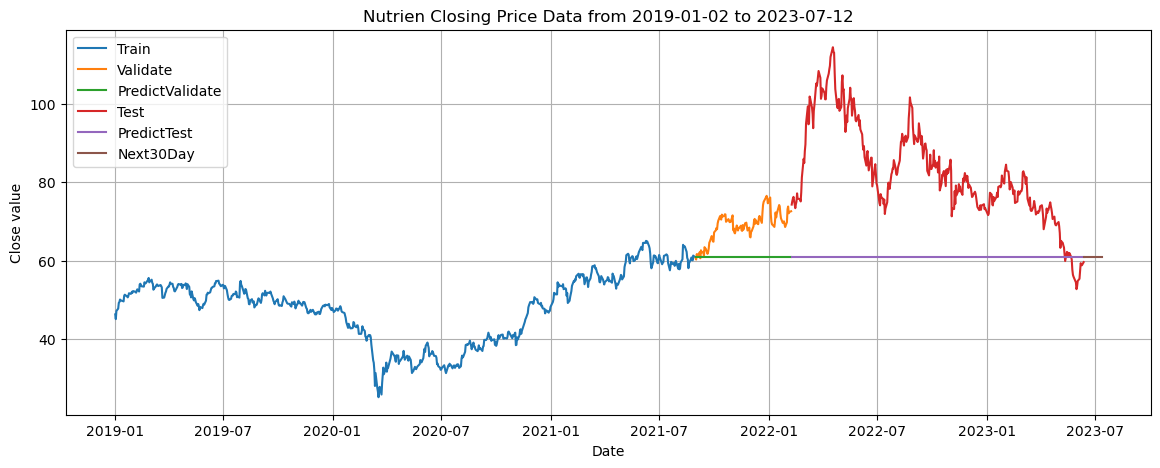

In [36]:
# Drawing
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))

plt.plot(df.index[train_size : train_size + val_size], y_val)

plt.plot(df.index[train_size : train_size + val_size], y_pred_val)

plt.plot(df.index[train_size + val_size :], y_test)

plt.plot(df.index[train_size + val_size :], y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('../Image/ARIMA_712_NTR.png')
plt.show()